In [1]:
!pip install sacremoses transformers torch pandas numpy scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 13.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found 

In [2]:
from nltk.tokenize import TweetTokenizer
from argparse import ArgumentParser
import itertools
import warnings
warnings.filterwarnings("ignore")

from transformers import BertConfig, BertTokenizer, BertForSequenceClassification, BertForPreTraining, BertModel
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import string
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import os
import shutil
import random
from torch import optim
from tqdm import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, 
                           classification_report, multilabel_confusion_matrix, confusion_matrix)
import seaborn as sns
from datetime import datetime
import argparse

2025-09-09 15:56:48.270137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757433408.468811      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757433408.525190      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_model(args):
    if 'indobenchmark' in args['model_checkpoint']:
        # Prepare config & tokenizer
        vocab_path, config_path = None, None
        tokenizer = BertTokenizer.from_pretrained(args['model_checkpoint'])
        config = BertConfig.from_pretrained(args['model_checkpoint'])
        
        if type(args['num_labels']) == list:
            config.num_labels = max(args['num_labels'])
            config.num_labels_list = args['num_labels']
        else:
            config.num_labels = args['num_labels']
        
        # Instantiate model
        model_class = None
        if 'sequence_classification' == args['task']:
            model_class = BertForSequenceClassification
        model = model_class.from_pretrained(args['model_checkpoint'], config=config)
        return model, tokenizer, vocab_path, config_path

In [4]:
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.FloatTensor(label_batch)  # Changed to FloatTensor for multi-label
    
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()
    
    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch)
    logits = outputs.logits
    
    # Multi-label loss (Binary Cross Entropy with Logits)
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(logits, label_batch)
    
    # Generate predictions for multi-label (threshold = 0.5)
    predictions = torch.sigmoid(logits) > 0.5
    
    # Convert to lists for metric calculation
    list_hyp = []
    list_label = []
    
    for j in range(len(predictions)):
        # Get predicted labels
        pred_labels = [i for i, pred in enumerate(predictions[j]) if pred.item()]
        true_labels = [i for i, label in enumerate(label_batch[j]) if label.item() == 1.0]
        
        list_hyp.append(pred_labels)
        list_label.append(true_labels)
    
    return loss, list_hyp, list_label

In [5]:
class EmotionDetectionDataset(Dataset):
    # Static constant variable with Indonesian emotion labels
    EMOTIONS = [
        "kekaguman", "kesenangan", "marah", "kesal", "persetujuan",
        "peduli", "bingung", "penasaran", "keinginan", "kecewa",
        "ketidaksetujuan", "jijik", "malu", "semangat", "takut",
        "terima kasih", "duka", "bahagia", "cinta", "cemas",
        "optimis", "bangga", "menyadari", "lega", "penyesalan",
        "sedih", "terkejut", "netral"
    ]
    
    LABEL2INDEX = {emotion: idx for idx, emotion in enumerate(EMOTIONS)}
    INDEX2LABEL = {idx: emotion for idx, emotion in enumerate(EMOTIONS)}
    NUM_LABELS = len(EMOTIONS)  # 28 labels
    
    def load_dataset(self, path):
        # Load dataset
        dataset = pd.read_csv(path)
        
        # Convert multi-label string to binary vector
        def parse_labels(label_str):
            # Create binary vector for all 28 labels
            binary_vector = [0] * self.NUM_LABELS
            if pd.isna(label_str) or label_str.strip() == '':
                return binary_vector
            
            # Parse comma-separated label indices
            label_indices = [int(idx.strip()) for idx in str(label_str).strip().split(',')]
            for idx in label_indices:
                if 0 <= idx < self.NUM_LABELS:
                    binary_vector[idx] = 1
            return binary_vector
        
        dataset['label_vector'] = dataset['label'].apply(parse_labels)
        return dataset
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, lowercase=True, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
        self.lowercase = lowercase
    
    def __getitem__(self, index):
        text = self.data.loc[index, 'text_translated']  # Changed from 'tweet' to 'text_translated'
        label_vector = self.data.loc[index, 'label_vector']
        
        if self.lowercase:
            text = text.lower()
        
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(label_vector), text
    
    def __len__(self):
        return len(self.data)

In [6]:
class EmotionDetectionDataLoader(DataLoader):
    def __init__(self, max_seq_len=128, *args, **kwargs):
        super(EmotionDetectionDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
    
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        label_batch = np.zeros((batch_size, EmotionDetectionDataset.NUM_LABELS), dtype=np.float32)  # Multi-label
        seq_list = []
        
        for i, (subwords, label_vector, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i, :len(subwords)] = subwords
            mask_batch[i, :len(subwords)] = 1
            label_batch[i] = label_vector
            seq_list.append(raw_seq)
        
        return subword_batch, mask_batch, label_batch, seq_list

In [7]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Function to check if running in a notebook environment
def in_notebook():
    try:
        get_ipython
        return True
    except NameError:
        return False

# Functions for logging and training
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    return ' '.join(f"{key}:{value:.5f}" for key, value in metric_dict.items())

In [8]:
def emotion_detection_metrics_fn(list_hyp, list_label):
    """
    Menghitung metrik evaluasi utama: Exact Match, F1-Macro, Precision-Macro, dan Recall-Macro.
    """
    num_labels = EmotionDetectionDataset.NUM_LABELS
    
    # Inisialisasi matriks biner
    y_true = np.zeros((len(list_label), num_labels))
    y_pred = np.zeros((len(list_hyp), num_labels))

    # Isi matriks berdasarkan list of list dari label/prediksi
    for i, true_labels in enumerate(list_label):
        for label in true_labels:
            y_true[i, label] = 1
    
    for i, pred_labels in enumerate(list_hyp):
        for label in pred_labels:
            y_pred[i, label] = 1

    # Hitung hanya metrik yang diinginkan
    metrics = {
        "EXACT_MATCH": np.all(y_true == y_pred, axis=1).mean(),
        "F1_MACRO": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "PRECISION_MACRO": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "RECALL_MACRO": recall_score(y_true, y_pred, average='macro', zero_division=0)
    }
    return metrics

In [9]:
class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []
        self.best_epoch = 0
        self.best_val_loss = float('inf')

        # Define colors
        self.train_color = '#3498db'
        self.valid_color = '#ff7f0e'
        self.best_line_color = '#e74c3c'

    def update_train(self, loss, metrics):
        self.train_losses.append(loss)
        self.train_metrics.append(metrics)

    def update_valid(self, loss, metrics, epoch):
        self.valid_losses.append(loss)
        self.valid_metrics.append(metrics)
        if loss < self.best_val_loss:
            self.best_val_loss = loss
            self.best_epoch = epoch

    def plot_metrics(self, save_dir):
        epochs = range(1, len(self.train_losses) + 1)
        plt.style.use('seaborn-v0_8-whitegrid')
        
        fig, axes = plt.subplots(1, 3, figsize=(21, 6))

        # Plot Loss
        axes[0].plot(epochs, self.train_losses, '-o', color=self.train_color, label='Training Loss')
        axes[0].plot(epochs, self.valid_losses, '-o', color=self.valid_color, label='Validation Loss')
        axes[0].axvline(x=self.best_epoch + 1, color=self.best_line_color, linestyle='--', label=f'Best Model (Epoch {self.best_epoch + 1})')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()

        # Plot F1 Macro
        train_f1 = [m['F1_MACRO'] for m in self.train_metrics]
        valid_f1 = [m['F1_MACRO'] for m in self.valid_metrics]
        axes[1].plot(epochs, train_f1, '-o', color=self.train_color, label='Training F1-Macro')
        axes[1].plot(epochs, valid_f1, '-o', color=self.valid_color, label='Validation F1-Macro')
        axes[1].axvline(x=self.best_epoch + 1, color=self.best_line_color, linestyle='--')
        axes[1].set_title('Training and Validation F1-Macro')
        axes[1].set_ylim(0, 1)
        axes[1].legend()

        # Plot Exact Match
        train_exact = [m['EXACT_MATCH'] for m in self.train_metrics]
        valid_exact = [m['EXACT_MATCH'] for m in self.valid_metrics]
        axes[2].plot(epochs, train_exact, '-o', color=self.train_color, label='Training Exact Match')
        axes[2].plot(epochs, valid_exact, '-o', color=self.valid_color, label='Validation Exact Match')
        axes[2].axvline(x=self.best_epoch + 1, color=self.best_line_color, linestyle='--')
        axes[2].set_title('Training and Validation Exact Match')
        axes[2].set_ylim(0, 1)
        axes[2].legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'combined_metrics.png'), dpi=300)
        plt.close()

    def save_metrics_to_csv(self, save_dir):
        data = []
        for epoch in range(len(self.train_losses)):
            epoch_data = {
                'Epoch': epoch + 1,
                'Train Loss': self.train_losses[epoch],
                'Valid Loss': self.valid_losses[epoch],
                'Train Exact Match': self.train_metrics[epoch]['EXACT_MATCH'],
                'Valid Exact Match': self.valid_metrics[epoch]['EXACT_MATCH'],
                'Train F1 Macro': self.train_metrics[epoch]['F1_MACRO'],
                'Valid F1 Macro': self.valid_metrics[epoch]['F1_MACRO'],
                'Train Precision Macro': self.train_metrics[epoch]['PRECISION_MACRO'],
                'Valid Precision Macro': self.valid_metrics[epoch]['PRECISION_MACRO'],
                'Train Recall Macro': self.train_metrics[epoch]['RECALL_MACRO'],
                'Valid Recall Macro': self.valid_metrics[epoch]['RECALL_MACRO'],
                'Is Best Epoch': epoch == self.best_epoch
            }
            data.append(epoch_data)
        df = pd.DataFrame(data)
        df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), index=False)

In [10]:
def evaluate(model, data_loader, forward_fn, metrics_fn, i2w, args, is_test=False):
    model.eval()
    total_loss = 0
    list_hyp, list_label, list_seq = [], [], []
    pbar = tqdm(data_loader, total=len(data_loader))

    with torch.no_grad():
        for i, batch_data in enumerate(pbar):
            batch_seq = batch_data[-1]
            loss, batch_hyp, batch_label = forward_fn(model, batch_data[:-1], i2w=i2w, device=args['device'])

            total_loss += loss.item()
            list_hyp.extend(batch_hyp)
            list_label.extend(batch_label)
            list_seq.extend(batch_seq)

            metrics = metrics_fn(list_hyp, list_label)
            desc = "TEST LOSS:" if is_test else "VALID LOSS:"
            pbar.set_description(f"{desc}{total_loss/(i+1):.4f} {metrics_to_string(metrics)}")

    if is_test:
        return total_loss, metrics, list_hyp, list_label, list_seq
    return total_loss, metrics

In [11]:
def train(model, train_loader, valid_loader, optimizer, forward_fn, metrics_fn, valid_criterion, i2w, args):
    best_val_loss = float('inf')
    count_stop = 0
    metrics_tracker = MetricsTracker()

    for epoch in range(args['n_epochs']):
        model.train()
        total_train_loss = 0
        list_hyp, list_label = [], []
        train_pbar = tqdm(train_loader, total=len(train_loader))

        for i, batch_data in enumerate(train_pbar):
            loss, batch_hyp, batch_label = forward_fn(model, batch_data[:-1], i2w=i2w, device=args['device'])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            list_hyp.extend(batch_hyp)
            list_label.extend(batch_label)

            train_pbar.set_description(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f} LR:{get_lr(optimizer):.8f}")

        # Calculate training metrics
        train_loss = total_train_loss / len(train_loader)
        train_metrics = metrics_fn(list_hyp, list_label)
        metrics_tracker.update_train(train_loss, train_metrics)

        print(f"(Epoch {epoch+1}) TRAIN LOSS:{train_loss:.4f} {metrics_to_string(train_metrics)} LR:{get_lr(optimizer):.8f}")

        # Validation step
        if (epoch+1) % args['evaluate_every'] == 0:
            val_loss, val_metrics = evaluate(model, valid_loader, forward_fn, metrics_fn, i2w, args, is_test=False)
            val_loss_avg = val_loss / len(valid_loader)

            # Update metrics tracker with current validation results
            metrics_tracker.update_valid(val_loss_avg, val_metrics, epoch)
            print(f"(Epoch {epoch+1}) VALID LOSS:{val_loss_avg:.4f} {metrics_to_string(val_metrics)}")

            # Early stopping based on validation loss
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                torch.save(model.state_dict(), os.path.join(args['model_dir'], "best_model.pt"))
                count_stop = 0
            else:
                count_stop += 1

            if count_stop == args['early_stop']:
                print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                break

    # Generate plots and save metrics
    metrics_tracker.plot_metrics(args['model_dir'])
    metrics_tracker.save_metrics_to_csv(args['model_dir'])

    return metrics_tracker

In [12]:
# Print label mapping
w2i, i2w = EmotionDetectionDataset.LABEL2INDEX, EmotionDetectionDataset.INDEX2LABEL
print("Label to Index mapping:")
for emotion, idx in w2i.items():
    print(f"{idx}: {emotion}")

# Configuration
args = {
    "experiment_name": "multilabel_emotion_experiment",
    "model_dir": "./model_dir",
    "task": "sequence_classification",
    "model_checkpoint": "indobenchmark/indobert-base-p1",
    "dataset_class": EmotionDetectionDataset,
    "train_set_path": "/kaggle/input/datasetimbalancegoemotionid/train.csv",  
    "valid_set_path": "/kaggle/input/datasetimbalancegoemotionid/valid.csv", 
    "test_set_path": "/kaggle/input/datasetimbalancegoemotionid/test.csv",    
    "dataloader_class": EmotionDetectionDataLoader,
    "num_labels": EmotionDetectionDataset.NUM_LABELS,
    "forward_fn": forward_sequence_classification,
    "metrics_fn": emotion_detection_metrics_fn,
    "word_tokenizer_class": TweetTokenizer,
    "valid_criterion": "F1_MACRO",
    "lr": 0.000004,  
    "max_seq_len": 128,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "test_batch_size": 32,
    "n_epochs": 10,
    "early_stop": 4,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "fp16": False,
    "force": True,
    "no_special_token": False,
    "lower": True,
    "seed": 42,
    "evaluate_every": 1
}

print(f"Using device: {args['device']}")
print(f"Number of emotion labels: {args['num_labels']}")

Label to Index mapping:
0: kekaguman
1: kesenangan
2: marah
3: kesal
4: persetujuan
5: peduli
6: bingung
7: penasaran
8: keinginan
9: kecewa
10: ketidaksetujuan
11: jijik
12: malu
13: semangat
14: takut
15: terima kasih
16: duka
17: bahagia
18: cinta
19: cemas
20: optimis
21: bangga
22: menyadari
23: lega
24: penyesalan
25: sedih
26: terkejut
27: netral
Using device: cuda
Number of emotion labels: 28


In [13]:
# Set seed and prepare model directory
set_seed(args['seed'])
if not os.path.exists(args["model_dir"]):
    os.makedirs(args["model_dir"], exist_ok=True)
elif args['force']:
    print(f'Overwriting model directory {args["model_dir"]}')
else:
    raise Exception(f"Model directory {args['model_dir']} already exists. Use --force to overwrite.")

# Load model and tokenizer
print("Loading model and tokenizer...")
model, tokenizer, vocab_path, config_path = load_model(args)
model = model.to(args['device'])
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

print("Preparing datasets...")
# Train dataset
train_dataset = args['dataset_class'](args['train_set_path'], tokenizer, 
                                     lowercase=args["lower"], no_special_token=args['no_special_token'])
train_loader = args['dataloader_class'](dataset=train_dataset, max_seq_len=args['max_seq_len'], 
                                       batch_size=args['train_batch_size'], num_workers=0, shuffle=True)

# Validation dataset
valid_dataset = args['dataset_class'](args['valid_set_path'], tokenizer, 
                                     lowercase=args["lower"], no_special_token=args['no_special_token'])
valid_loader = args['dataloader_class'](dataset=valid_dataset, max_seq_len=args['max_seq_len'], 
                                       batch_size=args['valid_batch_size'], num_workers=0, shuffle=False)

# Test dataset
test_dataset = args['dataset_class'](args['test_set_path'], tokenizer, 
                                    lowercase=args["lower"], no_special_token=args['no_special_token'])
test_loader = args['dataloader_class'](dataset=test_dataset, max_seq_len=args['max_seq_len'], 
                                      batch_size=args['test_batch_size'], num_workers=0, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Loading model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Preparing datasets...
Train samples: 43398
Valid samples: 5426
Test samples: 5427


In [14]:
print("=========== TRAINING PHASE ===========")
metrics_tracker = train(model, train_loader, valid_loader, optimizer, args['forward_fn'], 
                       args['metrics_fn'], args['valid_criterion'], i2w, args)

print("\nTraining completed!")
print(f"Best epoch: {metrics_tracker.best_epoch + 1}")
print(f"Best validation loss: {metrics_tracker.best_val_loss:.4f}")

=========== TRAINING PHASE ===========



(Epoch 1) TRAIN LOSS:0.1862 LR:0.00000400: 100%|██████████| 1357/1357 [03:28<00:00,  6.52it/s]


(Epoch 1) TRAIN LOSS:0.1862 EXACT_MATCH:0.04307 F1_MACRO:0.02951 PRECISION_MACRO:0.10037 RECALL_MACRO:0.01893 LR:0.00000400


VALID LOSS:0.1297 EXACT_MATCH:0.17729 F1_MACRO:0.09586 PRECISION_MACRO:0.15024 RECALL_MACRO:0.07444: 100%|██████████| 170/170 [00:18<00:00,  9.21it/s]


(Epoch 1) VALID LOSS:0.1297 EXACT_MATCH:0.17729 F1_MACRO:0.09586 PRECISION_MACRO:0.15024 RECALL_MACRO:0.07444


(Epoch 2) TRAIN LOSS:0.1181 LR:0.00000400: 100%|██████████| 1357/1357 [03:23<00:00,  6.67it/s]


(Epoch 2) TRAIN LOSS:0.1181 EXACT_MATCH:0.25798 F1_MACRO:0.11840 PRECISION_MACRO:0.31480 RECALL_MACRO:0.09631 LR:0.00000400


VALID LOSS:0.1068 EXACT_MATCH:0.29082 F1_MACRO:0.14837 PRECISION_MACRO:0.25031 RECALL_MACRO:0.12747: 100%|██████████| 170/170 [00:18<00:00,  9.28it/s]


(Epoch 2) VALID LOSS:0.1068 EXACT_MATCH:0.29082 F1_MACRO:0.14837 PRECISION_MACRO:0.25031 RECALL_MACRO:0.12747


(Epoch 3) TRAIN LOSS:0.1024 LR:0.00000400: 100%|██████████| 1357/1357 [03:23<00:00,  6.66it/s]


(Epoch 3) TRAIN LOSS:0.1024 EXACT_MATCH:0.32384 F1_MACRO:0.17986 PRECISION_MACRO:0.46957 RECALL_MACRO:0.14632 LR:0.00000400


VALID LOSS:0.0977 EXACT_MATCH:0.33800 F1_MACRO:0.23042 PRECISION_MACRO:0.47880 RECALL_MACRO:0.18996: 100%|██████████| 170/170 [00:18<00:00,  9.30it/s]


(Epoch 3) VALID LOSS:0.0977 EXACT_MATCH:0.33800 F1_MACRO:0.23042 PRECISION_MACRO:0.47880 RECALL_MACRO:0.18996


(Epoch 4) TRAIN LOSS:0.0940 LR:0.00000400: 100%|██████████| 1357/1357 [03:23<00:00,  6.66it/s]


(Epoch 4) TRAIN LOSS:0.0940 EXACT_MATCH:0.36820 F1_MACRO:0.24060 PRECISION_MACRO:0.51207 RECALL_MACRO:0.19364 LR:0.00000400


VALID LOSS:0.0939 EXACT_MATCH:0.36325 F1_MACRO:0.28748 PRECISION_MACRO:0.49075 RECALL_MACRO:0.23460: 100%|██████████| 170/170 [00:18<00:00,  9.23it/s]


(Epoch 4) VALID LOSS:0.0939 EXACT_MATCH:0.36325 F1_MACRO:0.28748 PRECISION_MACRO:0.49075 RECALL_MACRO:0.23460


(Epoch 5) TRAIN LOSS:0.0885 LR:0.00000400: 100%|██████████| 1357/1357 [03:24<00:00,  6.64it/s]


(Epoch 5) TRAIN LOSS:0.0885 EXACT_MATCH:0.40661 F1_MACRO:0.29769 PRECISION_MACRO:0.61311 RECALL_MACRO:0.23836 LR:0.00000400


VALID LOSS:0.0917 EXACT_MATCH:0.37818 F1_MACRO:0.30223 PRECISION_MACRO:0.55698 RECALL_MACRO:0.24535: 100%|██████████| 170/170 [00:18<00:00,  9.19it/s]


(Epoch 5) VALID LOSS:0.0917 EXACT_MATCH:0.37818 F1_MACRO:0.30223 PRECISION_MACRO:0.55698 RECALL_MACRO:0.24535


(Epoch 6) TRAIN LOSS:0.0837 LR:0.00000400: 100%|██████████| 1357/1357 [03:23<00:00,  6.66it/s]


(Epoch 6) TRAIN LOSS:0.0837 EXACT_MATCH:0.43940 F1_MACRO:0.34211 PRECISION_MACRO:0.61250 RECALL_MACRO:0.27597 LR:0.00000400


VALID LOSS:0.0915 EXACT_MATCH:0.40306 F1_MACRO:0.36523 PRECISION_MACRO:0.59071 RECALL_MACRO:0.30478: 100%|██████████| 170/170 [00:18<00:00,  9.26it/s]


(Epoch 6) VALID LOSS:0.0915 EXACT_MATCH:0.40306 F1_MACRO:0.36523 PRECISION_MACRO:0.59071 RECALL_MACRO:0.30478


(Epoch 7) TRAIN LOSS:0.0796 LR:0.00000400: 100%|██████████| 1357/1357 [03:24<00:00,  6.64it/s]


(Epoch 7) TRAIN LOSS:0.0796 EXACT_MATCH:0.46859 F1_MACRO:0.38269 PRECISION_MACRO:0.64510 RECALL_MACRO:0.30987 LR:0.00000400


VALID LOSS:0.0914 EXACT_MATCH:0.42038 F1_MACRO:0.36674 PRECISION_MACRO:0.57674 RECALL_MACRO:0.30699: 100%|██████████| 170/170 [00:18<00:00,  9.28it/s]


(Epoch 7) VALID LOSS:0.0914 EXACT_MATCH:0.42038 F1_MACRO:0.36674 PRECISION_MACRO:0.57674 RECALL_MACRO:0.30699


(Epoch 8) TRAIN LOSS:0.0756 LR:0.00000400: 100%|██████████| 1357/1357 [03:23<00:00,  6.65it/s]


(Epoch 8) TRAIN LOSS:0.0756 EXACT_MATCH:0.49848 F1_MACRO:0.41744 PRECISION_MACRO:0.64639 RECALL_MACRO:0.34158 LR:0.00000400


VALID LOSS:0.0928 EXACT_MATCH:0.41633 F1_MACRO:0.37757 PRECISION_MACRO:0.55858 RECALL_MACRO:0.31583: 100%|██████████| 170/170 [00:18<00:00,  9.26it/s]


(Epoch 8) VALID LOSS:0.0928 EXACT_MATCH:0.41633 F1_MACRO:0.37757 PRECISION_MACRO:0.55858 RECALL_MACRO:0.31583


(Epoch 9) TRAIN LOSS:0.0715 LR:0.00000400: 100%|██████████| 1357/1357 [03:23<00:00,  6.65it/s]


(Epoch 9) TRAIN LOSS:0.0715 EXACT_MATCH:0.52701 F1_MACRO:0.44826 PRECISION_MACRO:0.64987 RECALL_MACRO:0.37175 LR:0.00000400


VALID LOSS:0.0942 EXACT_MATCH:0.41946 F1_MACRO:0.37704 PRECISION_MACRO:0.56741 RECALL_MACRO:0.30895: 100%|██████████| 170/170 [00:19<00:00,  8.91it/s]


(Epoch 9) VALID LOSS:0.0942 EXACT_MATCH:0.41946 F1_MACRO:0.37704 PRECISION_MACRO:0.56741 RECALL_MACRO:0.30895


(Epoch 10) TRAIN LOSS:0.0681 LR:0.00000400: 100%|██████████| 1357/1357 [03:27<00:00,  6.54it/s]


(Epoch 10) TRAIN LOSS:0.0681 EXACT_MATCH:0.55152 F1_MACRO:0.47782 PRECISION_MACRO:0.69649 RECALL_MACRO:0.39906 LR:0.00000400


VALID LOSS:0.0960 EXACT_MATCH:0.40988 F1_MACRO:0.38517 PRECISION_MACRO:0.53623 RECALL_MACRO:0.32459: 100%|██████████| 170/170 [00:19<00:00,  8.66it/s]


(Epoch 10) VALID LOSS:0.0960 EXACT_MATCH:0.40988 F1_MACRO:0.38517 PRECISION_MACRO:0.53623 RECALL_MACRO:0.32459

Training completed!
Best epoch: 7
Best validation loss: 0.0914


In [15]:
print("=========== EVALUATION PHASE ===========")
# Load best model
model.load_state_dict(torch.load(os.path.join(args["model_dir"], "best_model.pt")))
test_loss, test_metrics, test_hyp, test_label, test_seq = evaluate(model, test_loader, args['forward_fn'],
                                                                   args['metrics_fn'], i2w, args, is_test=True)

# Print test metrics
print("\nTest Metrics:")
print(metrics_to_string(test_metrics))

# Convert predictions to readable format
def convert_labels_to_text(label_lists, idx_to_emotion):
    text_labels = []
    for label_list in label_lists:
        if len(label_list) == 0:
            text_labels.append("netral")
        else:
            emotions = [idx_to_emotion[idx] for idx in label_list]
            text_labels.append(", ".join(emotions))
    return text_labels

# Save results to files
hyp_text = convert_labels_to_text(test_hyp, EmotionDetectionDataset.INDEX2LABEL)
label_text = convert_labels_to_text(test_label, EmotionDetectionDataset.INDEX2LABEL)

result_df = pd.DataFrame({
    'text': test_seq,
    'predicted_emotions': hyp_text,
    'true_emotions': label_text,
    'predicted_indices': [str(labels) for labels in test_hyp],
    'true_indices': [str(labels) for labels in test_label]
})
result_df.to_csv(os.path.join(args["model_dir"], "prediction_result.csv"), index=False)

# Save final metrics
final_metrics = {
    'test_loss': test_loss / len(test_loader),
    **test_metrics
}
metric_df = pd.DataFrame([final_metrics])
metric_df.to_csv(os.path.join(args["model_dir"], "evaluation_result.csv"), index=False)

# Save model configuration
config = {
    'experiment_name': args['experiment_name'],
    'model_dir': args['model_dir'],
    'learning_rate': args['lr'],
    'max_seq_len': args['max_seq_len'],
    'batch_size': args['train_batch_size'],
    'n_epochs': args['n_epochs'],
    'early_stop': args['early_stop'],
    'seed': args['seed'],
    'device': args['device'],
    'lower': args['lower'],
    'no_special_token': args['no_special_token'],
    'num_labels': args['num_labels']
}
config_df = pd.DataFrame([config])
config_df.to_csv(os.path.join(args["model_dir"], "config.csv"), index=False)

print("\nTraining completed! Results saved in:", args["model_dir"])
print("Files saved:")
print("- best_model.pt: Best model weights")
print("- prediction_result.csv: Test set predictions with readable emotion names")
print("- evaluation_result.csv: Final test metrics")
print("- training_metrics.csv: Per-epoch training and validation metrics")
print("- config.csv: Model configuration")
print("- combined_metrics.png: All training curves")

=========== EVALUATION PHASE ===========


TEST LOSS:0.0906 EXACT_MATCH:0.42270 F1_MACRO:0.37592 PRECISION_MACRO:0.59067 RECALL_MACRO:0.31803: 100%|██████████| 170/170 [00:19<00:00,  8.71it/s]


Test Metrics:
EXACT_MATCH:0.42270 F1_MACRO:0.37592 PRECISION_MACRO:0.59067 RECALL_MACRO:0.31803

Training completed! Results saved in: ./model_dir
Files saved:
- best_model.pt: Best model weights
- prediction_result.csv: Test set predictions with readable emotion names
- evaluation_result.csv: Final test metrics
- training_metrics.csv: Per-epoch training and validation metrics
- config.csv: Model configuration
- combined_metrics.png: All training curves


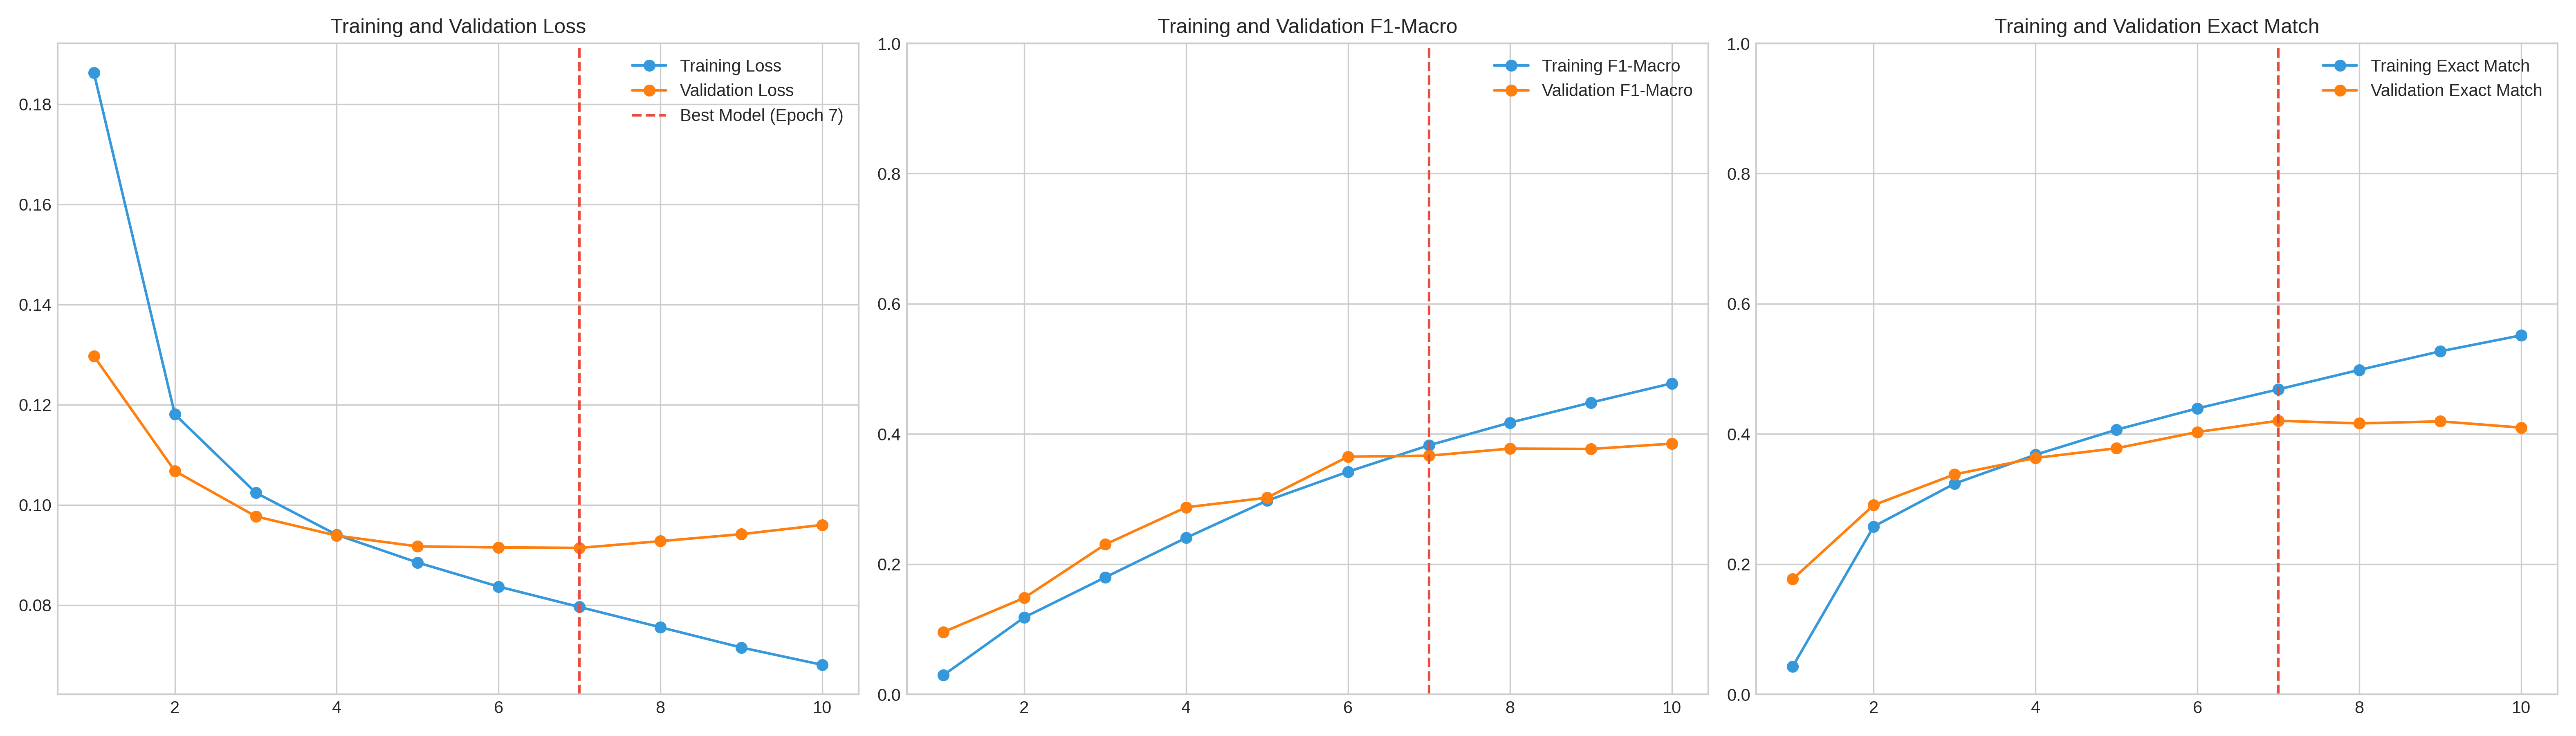

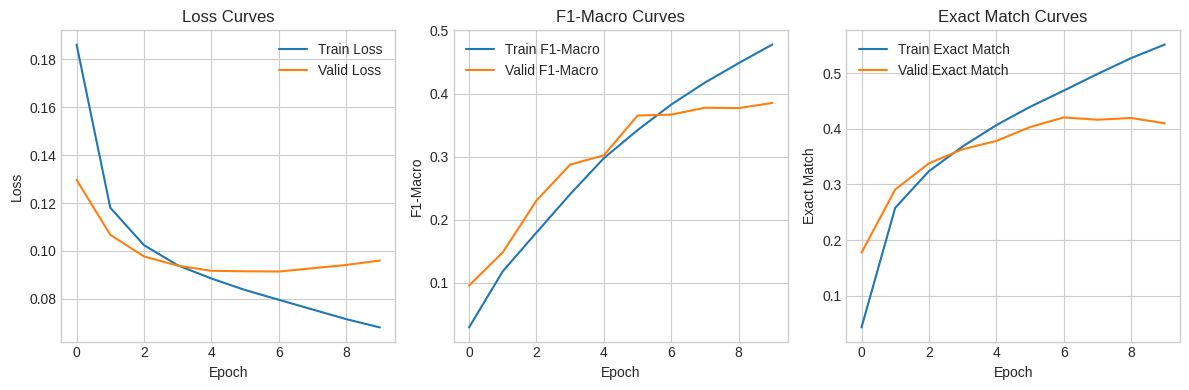

In [16]:
# Display the training curves
from IPython.display import Image, display
import matplotlib.pyplot as plt

# Show the saved plot
display(Image(os.path.join(args["model_dir"], 'combined_metrics.png')))

# Or create a simple summary plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(metrics_tracker.train_losses, label='Train Loss')
plt.plot(metrics_tracker.valid_losses, label='Valid Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
train_f1 = [m['F1_MACRO'] for m in metrics_tracker.train_metrics]
valid_f1 = [m['F1_MACRO'] for m in metrics_tracker.valid_metrics]
plt.plot(train_f1, label='Train F1-Macro')
plt.plot(valid_f1, label='Valid F1-Macro')
plt.title('F1-Macro Curves')
plt.xlabel('Epoch')
plt.ylabel('F1-Macro')
plt.legend()

plt.subplot(1, 3, 3)
train_exact = [m['EXACT_MATCH'] for m in metrics_tracker.train_metrics]
valid_exact = [m['EXACT_MATCH'] for m in metrics_tracker.valid_metrics]
plt.plot(train_exact, label='Train Exact Match')
plt.plot(valid_exact, label='Valid Exact Match')
plt.title('Exact Match Curves')
plt.xlabel('Epoch')
plt.ylabel('Exact Match')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan label mapping yang sudah didefinisikan sebelumnya
w2i, i2w = EmotionDetectionDataset.LABEL2INDEX, EmotionDetectionDataset.INDEX2LABEL
print("Label mapping:")
for idx, emotion in i2w.items():
    print(f"{idx}: {emotion}")

# Load the model and tokenizer untuk multi-label
def load_trained_model(model_path, num_labels=28):
    model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', num_labels=num_labels)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
    model.eval()  # Set to evaluation mode
    return model

# Define the path to the model directory and the model file
MODEL_DIR = './model_dir'  # Sesuaikan dengan path model Anda
MODEL_PATH = f"{MODEL_DIR}/best_model.pt"
NUM_LABELS = 28  # 28 emotion labels

# Load the model and tokenizer
trained_model = load_trained_model(MODEL_PATH, NUM_LABELS)
inference_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# Ensure the model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(device)

print(f"Model loaded successfully on device: {device}")

Label mapping:
0: kekaguman
1: kesenangan
2: marah
3: kesal
4: persetujuan
5: peduli
6: bingung
7: penasaran
8: keinginan
9: kecewa
10: ketidaksetujuan
11: jijik
12: malu
13: semangat
14: takut
15: terima kasih
16: duka
17: bahagia
18: cinta
19: cemas
20: optimis
21: bangga
22: menyadari
23: lega
24: penyesalan
25: sedih
26: terkejut
27: netral


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully on device: cuda


In [18]:
def predict_sentence_multilabel(model, tokenizer, sentence, max_seq_len=128, threshold=0.5):
    """
    Prediksi multi-label untuk satu kalimat.

    Args:
        model: Model yang sudah dilatih
        tokenizer: Tokenizer BERT
        sentence: Kalimat input
        max_seq_len: Panjang maksimum sequence
        threshold: Threshold untuk prediksi binary (default 0.5)

    Returns:
        predicted_indices: List index label yang diprediksi
        predicted_emotions: List nama emosi yang diprediksi
        probabilities: Array probabilitas untuk semua label
    """
    model.eval()

    # Tokenize and encode the input sentence
    inputs = tokenizer(sentence, return_tensors='pt', padding=True,
                      truncation=True, max_length=max_seq_len)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits)  # Sigmoid untuk multi-label

        # Prediksi berdasarkan threshold
        predictions = probabilities > threshold

        # Get predicted label indices
        predicted_indices = [i for i, pred in enumerate(predictions[0]) if pred.item()]

        # Convert indices to emotion names
        predicted_emotions = [i2w[idx] for idx in predicted_indices]

        return predicted_indices, predicted_emotions, probabilities[0].cpu().numpy()

# Test prediction function
test_sentence = "Saya sangat senang dan bangga dengan pencapaian ini!"
pred_indices, pred_emotions, probs = predict_sentence_multilabel(trained_model, inference_tokenizer, test_sentence)

print(f"Test sentence: {test_sentence}")
print(f"Predicted indices: {pred_indices}")
print(f"Predicted emotions: {pred_emotions}")
print(f"Top 5 probabilities:")
top_5_indices = np.argsort(probs)[-5:][::-1]
for idx in top_5_indices:
    print(f"  {i2w[idx]}: {probs[idx]:.4f}")

Test sentence: Saya sangat senang dan bangga dengan pencapaian ini!
Predicted indices: [17]
Predicted emotions: ['bahagia']
Top 5 probabilities:
  bahagia: 0.5677
  kekaguman: 0.4148
  terima kasih: 0.3238
  bangga: 0.1350
  semangat: 0.1040


In [19]:
def plot_multilabel_confusion_matrix(y_true_matrix, y_pred_matrix, emotion_names, save_path='multilabel_confusion_matrix.png'):
    """
    Plot confusion matrix untuk setiap label dalam multi-label classification.
    """
    n_labels = len(emotion_names)

    # Create multiple plots for better readability
    # Plot 1: Individual confusion matrices (7x4 grid)
    fig1, axes1 = plt.subplots(7, 4, figsize=(24, 42))
    axes1 = axes1.ravel()

    for i in range(n_labels):
        cm = confusion_matrix(y_true_matrix[:, i], y_pred_matrix[:, i])

        # Calculate metrics for title
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        else:
            precision = recall = f1 = 0

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes1[i],
                   xticklabels=['Tidak', 'Ya'],
                   yticklabels=['Tidak', 'Ya'],
                   cbar=True, square=True)

        axes1[i].set_title(f'{emotion_names[i]}\nF1: {f1:.3f} | P: {precision:.3f} | R: {recall:.3f}',
                          fontsize=11, fontweight='bold')
        axes1[i].set_xlabel('Prediksi', fontsize=10)
        axes1[i].set_ylabel('Ground Truth', fontsize=10)

        # Add support information
        support = y_true_matrix[:, i].sum()
        predicted = y_pred_matrix[:, i].sum()
        axes1[i].text(0.5, -0.15, f'Support: {support} | Predicted: {predicted}',
                     transform=axes1[i].transAxes, ha='center', fontsize=9)

    plt.suptitle('Confusion Matrix untuk Setiap Label Emosi\n(Multi-Label Classification)',
                 fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(save_path.replace('.png', '_individual.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # Plot 2: Performance heatmap
    fig2, ax2 = plt.subplots(figsize=(16, 12))

    # Calculate metrics for all labels
    metrics_data = []
    for i in range(n_labels):
        cm = confusion_matrix(y_true_matrix[:, i], y_pred_matrix[:, i])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            support = y_true_matrix[:, i].sum()
        else:
            precision = recall = f1 = support = 0

        metrics_data.append([precision, recall, f1, support])

    metrics_df = pd.DataFrame(metrics_data,
                             columns=['Precision', 'Recall', 'F1-Score', 'Support'],
                             index=emotion_names)

    # Create heatmap
    sns.heatmap(metrics_df[['Precision', 'Recall', 'F1-Score']],
                annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax2,
                cbar_kws={'label': 'Score'})

    ax2.set_title('Performance Metrics per Label Emosi', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Metrics', fontsize=12)
    ax2.set_ylabel('Label Emosi', fontsize=12)
    ax2.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.savefig(save_path.replace('.png', '_performance_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # Plot 3: Label distribution comparison
    fig3, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 10))

    # True label distribution
    true_counts = y_true_matrix.sum(axis=0)
    pred_counts = y_pred_matrix.sum(axis=0)

    x_pos = np.arange(len(emotion_names))

    ax3.bar(x_pos - 0.2, true_counts, 0.4, label='Ground Truth', alpha=0.8, color='skyblue')
    ax3.bar(x_pos + 0.2, pred_counts, 0.4, label='Predicted', alpha=0.8, color='orange')

    ax3.set_xlabel('Label Emosi', fontsize=12)
    ax3.set_ylabel('Frekuensi', fontsize=12)
    ax3.set_title('Distribusi Label: Ground Truth vs Predicted', fontsize=14, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(emotion_names, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # Performance vs Support scatter plot
    support_values = y_true_matrix.sum(axis=0)
    f1_values = [metrics_data[i][2] for i in range(n_labels)]

    scatter = ax4.scatter(support_values, f1_values, s=100, alpha=0.7, c=range(len(emotion_names)), cmap='tab10')

    # Add labels for each point
    for i, emotion in enumerate(emotion_names):
        ax4.annotate(emotion, (support_values[i], f1_values[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax4.set_xlabel('Support (Jumlah Instances dalam Ground Truth)', fontsize=12)
    ax4.set_ylabel('F1-Score', fontsize=12)
    ax4.set_title('F1-Score vs Support per Label', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path.replace('.png', '_distribution_analysis.png'), dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Confusion matrix visualizations saved:")
    print(f"  - Individual matrices: {save_path.replace('.png', '_individual.png')}")
    print(f"  - Performance heatmap: {save_path.replace('.png', '_performance_heatmap.png')}")
    print(f"  - Distribution analysis: {save_path.replace('.png', '_distribution_analysis.png')}")

    return metrics_df

def analyze_label_performance(y_true_matrix, y_pred_matrix, emotion_names):
    """
    Analisis performa per label dengan detail lengkap.
    """
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

    results = []
    detailed_metrics = {}

    for i, emotion in enumerate(emotion_names):
        # Calculate basic metrics
        precision = precision_score(y_true_matrix[:, i], y_pred_matrix[:, i], zero_division=0)
        recall = recall_score(y_true_matrix[:, i], y_pred_matrix[:, i], zero_division=0)
        f1 = f1_score(y_true_matrix[:, i], y_pred_matrix[:, i], zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true_matrix[:, i], y_pred_matrix[:, i])

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle case where there are no positive or negative samples
            if cm.shape == (1, 1):
                if y_true_matrix[:, i].sum() == 0:  # No positive samples
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:  # No negative samples
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0

        # Calculate additional metrics
        support = y_true_matrix[:, i].sum()
        predicted_positive = y_pred_matrix[:, i].sum()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

        # Calculate rates
        true_positive_rate = recall  # Same as recall/sensitivity
        false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

        # Store results
        results.append({
            'Emotion': emotion,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': specificity,
            'Support': support,
            'Predicted_Positive': predicted_positive,
            'True_Positive': tp,
            'False_Positive': fp,
            'True_Negative': tn,
            'False_Negative': fn,
            'TPR': true_positive_rate,
            'FPR': false_positive_rate,
            'FNR': false_negative_rate,
            'NPV': npv
        })

        # Store detailed metrics for individual analysis
        detailed_metrics[emotion] = {
            'confusion_matrix': cm,
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
            'precision': precision, 'recall': recall, 'f1': f1,
            'specificity': specificity, 'support': support
        }

    results_df = pd.DataFrame(results)

    # Sort by F1-Score descending
    results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

    return results_df, detailed_metrics

def create_comprehensive_confusion_matrix_report(y_true_matrix, y_pred_matrix, emotion_names, save_dir='./'):
    """
    Create comprehensive confusion matrix report with multiple visualizations.
    """
    # Analyze performance
    performance_df, detailed_metrics = analyze_label_performance(y_true_matrix, y_pred_matrix, emotion_names)

    # 1. Create summary table
    print("="*80)
    print("CONFUSION MATRIX ANALYSIS - SUMMARY")
    print("="*80)

    # Display top 10 and bottom 5 performers
    print("\nTOP 10 PERFORMING EMOTIONS:")
    top_10 = performance_df.head(10)[['Emotion', 'F1-Score', 'Precision', 'Recall', 'Support']]
    print(top_10.to_string(index=False, float_format='%.4f'))

    print("\nBOTTOM 5 PERFORMING EMOTIONS:")
    bottom_5 = performance_df.tail(5)[['Emotion', 'F1-Score', 'Precision', 'Recall', 'Support']]
    print(bottom_5.to_string(index=False, float_format='%.4f'))

    # 2. Create detailed confusion matrices visualization
    metrics_df = plot_multilabel_confusion_matrix(y_true_matrix, y_pred_matrix, emotion_names,
                                                 os.path.join(save_dir, 'multilabel_confusion_matrix.png'))

    # 3. Create classification report style output
    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*80)

    print(f"{'Emotion':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10} {'Predicted':<10}")
    print("-" * 75)

    for _, row in performance_df.iterrows():
        print(f"{row['Emotion']:<15} {row['Precision']:<10.4f} {row['Recall']:<10.4f} "
              f"{row['F1-Score']:<10.4f} {row['Support']:<10.0f} {row['Predicted_Positive']:<10.0f}")

    # Calculate overall metrics
    macro_precision = performance_df['Precision'].mean()
    macro_recall = performance_df['Recall'].mean()
    macro_f1 = performance_df['F1-Score'].mean()

    # Weighted averages
    weighted_precision = (performance_df['Precision'] * performance_df['Support']).sum() / performance_df['Support'].sum()
    weighted_recall = (performance_df['Recall'] * performance_df['Support']).sum() / performance_df['Support'].sum()
    weighted_f1 = (performance_df['F1-Score'] * performance_df['Support']).sum() / performance_df['Support'].sum()

    print("-" * 75)
    print(f"{'macro avg':<15} {macro_precision:<10.4f} {macro_recall:<10.4f} {macro_f1:<10.4f} {performance_df['Support'].sum():<10.0f}")
    print(f"{'weighted avg':<15} {weighted_precision:<10.4f} {weighted_recall:<10.4f} {weighted_f1:<10.4f} {performance_df['Support'].sum():<10.0f}")

    # 4. Save detailed results
    performance_df.to_csv(os.path.join(save_dir, 'detailed_confusion_matrix_analysis.csv'), index=False)

    # 5. Create problem analysis
    print("\n" + "="*80)
    print("PROBLEM ANALYSIS")
    print("="*80)

    # Find emotions with specific problems
    low_precision = performance_df[performance_df['Precision'] < 0.3]['Emotion'].tolist()
    low_recall = performance_df[performance_df['Recall'] < 0.3]['Emotion'].tolist()
    low_support = performance_df[performance_df['Support'] < 50]['Emotion'].tolist()
    high_fp = performance_df[performance_df['False_Positive'] > performance_df['True_Positive']]['Emotion'].tolist()

    if low_precision:
        print(f"⚠️  Low Precision (< 0.3): {', '.join(low_precision)}")
        print("   → Model predicts these emotions too often (many false positives)")

    if low_recall:
        print(f"⚠️  Low Recall (< 0.3): {', '.join(low_recall)}")
        print("   → Model misses these emotions too often (many false negatives)")

    if low_support:
        print(f"⚠️  Low Support (< 50 samples): {', '.join(low_support)}")
        print("   → These emotions have very few examples in the dataset")

    if high_fp:
        print(f"⚠️  High False Positives: {', '.join(high_fp)}")
        print("   → Model confuses other emotions with these")

    # 6. Recommendations
    print("\n" + "="*50)
    print("RECOMMENDATIONS")
    print("="*50)

    if low_support:
        print("📈 Data Collection:")
        print("   - Collect more examples for low-support emotions")
        print("   - Consider data augmentation for rare emotions")

    if low_precision:
        print("🎯 Threshold Tuning:")
        print("   - Increase threshold for emotions with low precision")
        print("   - Use class-specific thresholds")

    if low_recall:
        print("🔍 Model Improvement:")
        print("   - Consider focal loss for imbalanced classes")
        print("   - Adjust class weights during training")

    print("\n✅ Confusion matrix analysis completed!")
    print(f"📁 Files saved in: {save_dir}")

    return performance_df, detailed_metrics

def evaluate_multilabel_model(test_data, true_label_lists, model, tokenizer, threshold=0.5):
    """
    Evaluasi model multi-label.

    Args:
        test_data (list): List teks untuk evaluasi
        true_label_lists (list): List of lists, setiap inner list berisi true label indices
        model: Model yang sudah dilatih
        tokenizer: Tokenizer
        threshold: Threshold untuk prediksi

    Returns:
        dict: Metrics evaluasi
        DataFrame: Sample predictions
        list: All predictions
        DataFrame: Full results
    """
    predicted_label_lists = []
    all_probabilities = []

    print(f"Evaluating {len(test_data)} samples...")

    for i, text in enumerate(test_data):
        if i % 1000 == 0:
            print(f"Processing {i}/{len(test_data)}")

        pred_indices, pred_emotions, probabilities = predict_sentence_multilabel(
            model, tokenizer, text, threshold=threshold
        )
        predicted_label_lists.append(pred_indices)
        all_probabilities.append(probabilities)

    # Hitung metrics menggunakan fungsi yang sudah ada
    metrics = emotion_detection_metrics_fn(predicted_label_lists, true_label_lists)

    # Buat DataFrame untuk sample
    def format_labels(label_list):
        if len(label_list) == 0:
            return "netral"
        return ", ".join([i2w[idx] for idx in label_list])

    df = pd.DataFrame({
        'text': test_data,
        'true_labels': [str(labels) for labels in true_label_lists],
        'predicted_labels': [str(labels) for labels in predicted_label_lists],
        'true_emotions': [format_labels(labels) for labels in true_label_lists],
        'predicted_emotions': [format_labels(labels) for labels in predicted_label_lists],
        'probabilities': all_probabilities
    })

    # Ambil sample untuk verifikasi
    sample_df = df.sample(min(20, len(df)), random_state=42)

    return metrics, sample_df, predicted_label_lists, df

In [20]:
# Load test data dengan format yang benar
test_data_path = '/kaggle/input/datasetimbalancegoemotionid/test.csv'  # Sesuaikan dengan path file Anda
test_df = pd.read_csv(test_data_path)

print(f"Test dataset shape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}")

# Extract texts dan true labels
test_texts = test_df['text_translated'].tolist()

# Parse true labels dari format string ke list of lists
def parse_label_string(label_str):
    """Parse label string seperti '0,1,2' menjadi list [0,1,2]"""
    if pd.isna(label_str) or label_str.strip() == '':
        return []
    
    # Parse comma-separated label indices
    try:
        label_indices = [int(idx.strip()) for idx in str(label_str).strip().split(',')]
        return [idx for idx in label_indices if 0 <= idx < 28]  # Validasi range
    except:
        return []

true_label_lists = test_df['label'].apply(parse_label_string).tolist()

print(f"Number of test samples: {len(test_texts)}")
print(f"Sample true labels: {true_label_lists[:5]}")

# Contoh beberapa sample
print("\nSample data:")
for i in range(3):
    emotions = [i2w[idx] for idx in true_label_lists[i]] if true_label_lists[i] else ["netral"]
    print(f"{i+1}. Text: {test_texts[i][:100]}...")
    print(f"   True emotions: {', '.join(emotions)}")
    print()

Test dataset shape: (5427, 2)
Columns: ['text_translated', 'label']
Number of test samples: 5427
Sample true labels: [[25], [0], [13], [15], [27]]

Sample data:
1. Text: Saya sangat menyesal tentang situasi Anda :( Meskipun saya suka nama Sapphira, Cirilla, dan Scarlett...
   True emotions: sedih

2. Text: Luar biasa karena mengerikan.Tidak dengan....
   True emotions: kekaguman

3. Text: Penggemar Kings di sini, semoga sukses untuk kalian!Akan menjadi permainan yang menarik untuk ditont...
   True emotions: semangat



In [21]:
# Jalankan evaluasi
print("Starting evaluation...")
metrics, sample_df, predicted_label_lists, full_df = evaluate_multilabel_model(
    test_texts, true_label_lists, trained_model, inference_tokenizer, threshold=0.5
)

# Tampilkan hasil evaluasi
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

print("\nOverall Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.5f}")

Starting evaluation...
Evaluating 5427 samples...
Processing 0/5427
Processing 1000/5427
Processing 2000/5427
Processing 3000/5427
Processing 4000/5427
Processing 5000/5427

EVALUATION RESULTS

Overall Metrics:
EXACT_MATCH: 0.42270
F1_MACRO: 0.37592
PRECISION_MACRO: 0.59067
RECALL_MACRO: 0.31803


In [22]:
# Convert predictions ke binary matrix untuk analisis detail
def convert_to_binary_matrix(label_lists, num_labels=28):
    """Convert list of label lists ke binary matrix"""
    matrix = np.zeros((len(label_lists), num_labels), dtype=int)
    for i, labels in enumerate(label_lists):
        for label in labels:
            if 0 <= label < num_labels:
                matrix[i, label] = 1
    return matrix

# Convert ke binary matrices
y_true_matrix = convert_to_binary_matrix(true_label_lists)
y_pred_matrix = convert_to_binary_matrix(predicted_label_lists)

print(f"Binary matrix shapes - True: {y_true_matrix.shape}, Pred: {y_pred_matrix.shape}")

# Comprehensive confusion matrix analysis
emotion_names = [i2w[i] for i in range(28)]
performance_df, detailed_metrics = create_comprehensive_confusion_matrix_report(
    y_true_matrix, y_pred_matrix, emotion_names, save_dir='./'
)

Binary matrix shapes - True: (5427, 28), Pred: (5427, 28)
CONFUSION MATRIX ANALYSIS - SUMMARY

TOP 10 PERFORMING EMOTIONS:
     Emotion  F1-Score  Precision  Recall  Support
terima kasih    0.9162     0.9324  0.9006      352
       cinta    0.7627     0.7692  0.7563      238
  kesenangan    0.7569     0.7846  0.7311      264
   kekaguman    0.6522     0.6796  0.6270      504
  penyesalan    0.6050     0.5714  0.6429       56
      netral    0.6041     0.6854  0.5400     1787
       takut    0.5507     0.6333  0.4872       78
       sedih    0.5410     0.7500  0.4231      156
   penasaran    0.5236     0.5190  0.5282      284
     bahagia    0.5171     0.6667  0.4224      161

BOTTOM 5 PERFORMING EMOTIONS:
Emotion  F1-Score  Precision  Recall  Support
 kecewa    0.0510     0.6667  0.0265      151
  cemas    0.0000     0.0000  0.0000       23
   duka    0.0000     0.0000  0.0000        6
   lega    0.0000     0.0000  0.0000       11
 bangga    0.0000     0.0000  0.0000       16
Confusion

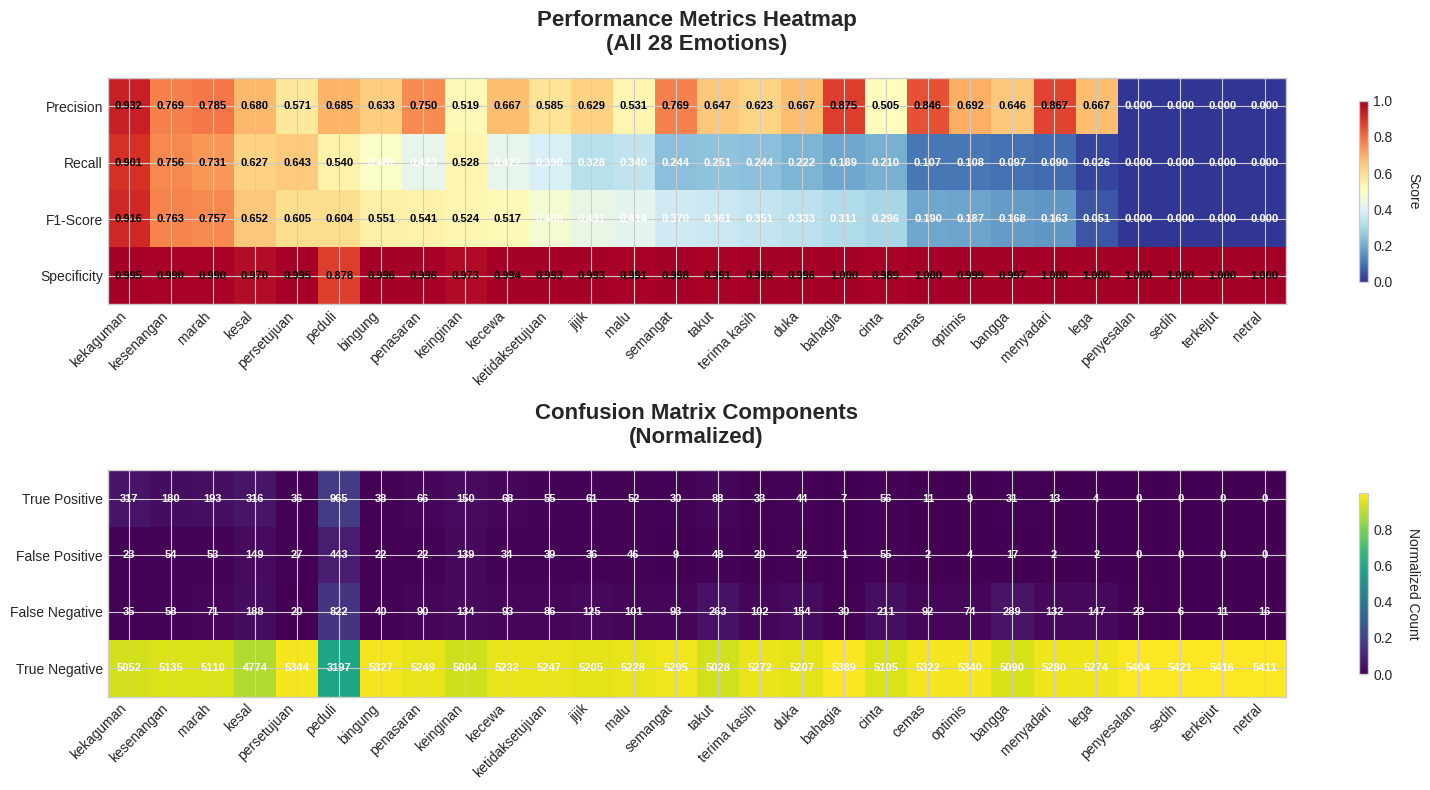


INDIVIDUAL EMOTION ANALYSIS

TOP 5 PERFORMING EMOTIONS:
--------------------------------------------------

1. TERIMA KASIH
   F1-Score: 0.9162
   Precision: 0.9324
   Recall: 0.9006
   Support: 352
   Confusion Matrix: TP=317, FP=23, FN=35, TN=5052

2. CINTA
   F1-Score: 0.7627
   Precision: 0.7692
   Recall: 0.7563
   Support: 238
   Confusion Matrix: TP=180, FP=54, FN=58, TN=5135

3. KESENANGAN
   F1-Score: 0.7569
   Precision: 0.7846
   Recall: 0.7311
   Support: 264
   Confusion Matrix: TP=193, FP=53, FN=71, TN=5110

4. KEKAGUMAN
   F1-Score: 0.6522
   Precision: 0.6796
   Recall: 0.6270
   Support: 504
   Confusion Matrix: TP=316, FP=149, FN=188, TN=4774

5. PENYESALAN
   F1-Score: 0.6050
   Precision: 0.5714
   Recall: 0.6429
   Support: 56
   Confusion Matrix: TP=36, FP=27, FN=20, TN=5344

BOTTOM 5 PERFORMING EMOTIONS:
--------------------------------------------------

1. KECEWA
   F1-Score: 0.0510
   Precision: 0.6667
   Recall: 0.0265
   Support: 151
   Confusion Matrix: TP

In [23]:
# Fungsi tambahan untuk analisis confusion matrix yang lebih interaktif
def create_emotion_confusion_heatmap(performance_df, emotion_names, save_path='emotion_performance_heatmap.png'):
    """
    Create an interactive heatmap showing all confusion matrix metrics.
    """
    # Prepare data for heatmap
    metrics_matrix = performance_df[['Precision', 'Recall', 'F1-Score', 'Specificity']].values
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
    
    # Heatmap 1: Performance metrics
    im1 = ax1.imshow(metrics_matrix.T, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
    
    # Set ticks and labels
    ax1.set_xticks(range(len(emotion_names)))
    ax1.set_xticklabels(emotion_names, rotation=45, ha='right')
    ax1.set_yticks(range(4))
    ax1.set_yticklabels(['Precision', 'Recall', 'F1-Score', 'Specificity'])
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Score', rotation=270, labelpad=20)
    
    # Add text annotations
    for i in range(len(emotion_names)):
        for j in range(4):
            text = ax1.text(i, j, f'{metrics_matrix[i, j]:.3f}',
                           ha="center", va="center", color="black" if metrics_matrix[i, j] > 0.5 else "white",
                           fontsize=8, weight='bold')
    
    ax1.set_title('Performance Metrics Heatmap\n(All 28 Emotions)', fontsize=16, weight='bold', pad=20)
    
    # Heatmap 2: Confusion matrix components
    confusion_data = performance_df[['True_Positive', 'False_Positive', 'False_Negative', 'True_Negative']].values
    confusion_normalized = confusion_data / (confusion_data.sum(axis=1, keepdims=True) + 1e-8)  # Normalize
    
    im2 = ax2.imshow(confusion_normalized.T, cmap='viridis', aspect='auto', interpolation='nearest')
    
    ax2.set_xticks(range(len(emotion_names)))
    ax2.set_xticklabels(emotion_names, rotation=45, ha='right')
    ax2.set_yticks(range(4))
    ax2.set_yticklabels(['True Positive', 'False Positive', 'False Negative', 'True Negative'])
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Normalized Count', rotation=270, labelpad=20)
    
    # Add text annotations
    for i in range(len(emotion_names)):
        for j in range(4):
            text = ax2.text(i, j, f'{confusion_data[i, j]:.0f}',
                           ha="center", va="center", color="white",
                           fontsize=8, weight='bold')
    
    ax2.set_title('Confusion Matrix Components\n(Normalized)', fontsize=16, weight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Fungsi untuk analisis per-emotion yang detail
def analyze_individual_emotions(detailed_metrics, emotion_names, top_n=5):
    """
    Analyze individual emotions in detail.
    """
    print("\n" + "="*80)
    print("INDIVIDUAL EMOTION ANALYSIS")
    print("="*80)
    
    # Sort emotions by F1-score
    sorted_emotions = sorted(detailed_metrics.items(), key=lambda x: x[1]['f1'], reverse=True)
    
    print(f"\nTOP {top_n} PERFORMING EMOTIONS:")
    print("-" * 50)
    
    for i, (emotion, metrics) in enumerate(sorted_emotions[:top_n]):
        cm = metrics['confusion_matrix']
        print(f"\n{i+1}. {emotion.upper()}")
        print(f"   F1-Score: {metrics['f1']:.4f}")
        print(f"   Precision: {metrics['precision']:.4f}")
        print(f"   Recall: {metrics['recall']:.4f}")
        print(f"   Support: {metrics['support']}")
        
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"   Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
            
            # Analysis
            if fp > tp:
                print(f"   ⚠️  Issue: More false positives ({fp}) than true positives ({tp})")
            if fn > tp:
                print(f"   ⚠️  Issue: More false negatives ({fn}) than true positives ({tp})")
            if metrics['precision'] < 0.5:
                print(f"   💡 Suggestion: Increase threshold for this emotion")
            if metrics['recall'] < 0.5:
                print(f"   💡 Suggestion: Collect more training data or adjust model")
    
    print(f"\nBOTTOM {top_n} PERFORMING EMOTIONS:")
    print("-" * 50)
    
    for i, (emotion, metrics) in enumerate(sorted_emotions[-top_n:]):
        cm = metrics['confusion_matrix']
        print(f"\n{i+1}. {emotion.upper()}")
        print(f"   F1-Score: {metrics['f1']:.4f}")
        print(f"   Precision: {metrics['precision']:.4f}")
        print(f"   Recall: {metrics['recall']:.4f}")
        print(f"   Support: {metrics['support']}")
        
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"   Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
            
            # Analysis and suggestions
            if metrics['support'] < 50:
                print(f"   ⚠️  Issue: Very low support ({metrics['support']} samples)")
                print(f"   💡 Suggestion: Collect more data for this emotion")
            
            if tp == 0:
                print(f"   ⚠️  Critical: No true positives detected!")
                print(f"   💡 Suggestion: Check data quality and model training")
            
            if metrics['f1'] < 0.1:
                print(f"   💡 Suggestion: Consider removing this emotion or combining with similar emotions")

# Create comprehensive visualization
fig = create_emotion_confusion_heatmap(performance_df, emotion_names)

# Detailed individual analysis
analyze_individual_emotions(detailed_metrics, emotion_names, top_n=5)

In [24]:
def analyze_threshold_impact(test_texts, true_label_lists, model, tokenizer, thresholds=[0.5]):
    """
    Analyze the impact of different thresholds on performance.
    """
    print("Analyzing threshold impact (this may take a while)...")
    
    threshold_results = []
    
    for threshold in thresholds:
        print(f"Testing threshold: {threshold}")
        
        # Get predictions with current threshold
        predicted_label_lists = []
        for text in test_texts[:1000]:  # Use subset for speed
            pred_indices, _, _ = predict_sentence_multilabel(
                model, tokenizer, text, threshold=threshold
            )
            predicted_label_lists.append(pred_indices)
        
        # Calculate metrics
        y_true_subset = convert_to_binary_matrix(true_label_lists[:1000])
        y_pred_subset = convert_to_binary_matrix(predicted_label_lists)
        
        # Calculate overall metrics
        exact_match = np.all(y_true_subset == y_pred_subset, axis=1).mean()
        
        # Calculate per-label metrics
        precisions = []
        recalls = []
        f1s = []
        
        for i in range(28):
            if y_true_subset[:, i].sum() > 0:  # Only if there are positive samples
                prec = precision_score(y_true_subset[:, i], y_pred_subset[:, i], zero_division=0)
                rec = recall_score(y_true_subset[:, i], y_pred_subset[:, i], zero_division=0)
                f1 = f1_score(y_true_subset[:, i], y_pred_subset[:, i], zero_division=0)
                
                precisions.append(prec)
                recalls.append(rec)
                f1s.append(f1)
        
        avg_precision = np.mean(precisions) if precisions else 0
        avg_recall = np.mean(recalls) if recalls else 0
        avg_f1 = np.mean(f1s) if f1s else 0
        
        # Count predictions
        total_predicted = y_pred_subset.sum()
        total_true = y_true_subset.sum()
        
        threshold_results.append({
            'threshold': threshold,
            'exact_match': exact_match,
            'avg_precision': avg_precision,
            'avg_recall': avg_recall,
            'avg_f1': avg_f1,
            'total_predicted': total_predicted,
            'total_true': total_true,
            'prediction_ratio': total_predicted / total_true if total_true > 0 else 0
        })
    
    # Create threshold analysis DataFrame
    threshold_df = pd.DataFrame(threshold_results)
    
    # Plot threshold analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Precision, Recall, F1 vs Threshold
    ax1 = axes[0, 0]
    ax1.plot(threshold_df['threshold'], threshold_df['avg_precision'], 'b-o', label='Precision')
    ax1.plot(threshold_df['threshold'], threshold_df['avg_recall'], 'r-o', label='Recall')
    ax1.plot(threshold_df['threshold'], threshold_df['avg_f1'], 'g-o', label='F1-Score')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance vs Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Exact Match vs Threshold
    ax2 = axes[0, 1]
    ax2.plot(threshold_df['threshold'], threshold_df['exact_match'], 'purple', marker='o')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Exact Match Accuracy')
    ax2.set_title('Exact Match vs Threshold')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Prediction Count vs Threshold
    ax3 = axes[1, 0]
    ax3.plot(threshold_df['threshold'], threshold_df['total_predicted'], 'orange', marker='o', label='Predicted')
    ax3.axhline(y=threshold_df['total_true'].iloc[0], color='red', linestyle='--', label='True Labels')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('Total Label Count')
    ax3.set_title('Label Count vs Threshold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Prediction Ratio vs Threshold
    ax4 = axes[1, 1]
    ax4.plot(threshold_df['threshold'], threshold_df['prediction_ratio'], 'brown', marker='o')
    ax4.axhline(y=1.0, color='red', linestyle='--', label='Perfect Ratio')
    ax4.set_xlabel('Threshold')
    ax4.set_ylabel('Predicted/True Ratio')
    ax4.set_title('Prediction Ratio vs Threshold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find optimal threshold
    optimal_idx = threshold_df['avg_f1'].idxmax()
    optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
    
    print(f"\nTHRESHOLD ANALYSIS RESULTS:")
    print(f"{'='*50}")
    print(threshold_df.round(4))
    
    print(f"\n🎯 OPTIMAL THRESHOLD: {optimal_threshold}")
    print(f"   F1-Score: {threshold_df.loc[optimal_idx, 'avg_f1']:.4f}")
    print(f"   Precision: {threshold_df.loc[optimal_idx, 'avg_precision']:.4f}")
    print(f"   Recall: {threshold_df.loc[optimal_idx, 'avg_recall']:.4f}")
    print(f"   Exact Match: {threshold_df.loc[optimal_idx, 'exact_match']:.4f}")
    
    return threshold_df, optimal_threshold

In [25]:
# Simpan hasil evaluasi ke file Excel yang lebih comprehensive
output_file = 'comprehensive_multilabel_evaluation.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Sheet 1: Overall metrics
    metrics_df = pd.DataFrame({
        'Metric': list(metrics.keys()),
        'Value': list(metrics.values())
    })
    metrics_df.to_excel(writer, sheet_name='Overall Metrics', index=False)
    
    # Sheet 2: Detailed performance per emotion (dari confusion matrix analysis)
    performance_df.to_excel(writer, sheet_name='Performance per Emotion', index=False)
    
    # Sheet 3: Sample predictions
    sample_df[['text', 'true_emotions', 'predicted_emotions', 'true_labels', 'predicted_labels']].to_excel(
        writer, sheet_name='Sample Predictions', index=False
    )
    
    # Sheet 4: Confusion matrix details
    cm_details = []
    for emotion, details in detailed_metrics.items():
        cm = details['confusion_matrix']
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            cm_details.append({
                'Emotion': emotion,
                'True_Negative': tn,
                'False_Positive': fp,
                'False_Negative': fn,
                'True_Positive': tp,
                'Sensitivity_Recall': details['recall'],
                'Specificity': details['specificity'],
                'Precision': details['precision'],
                'F1_Score': details['f1'],
                'Support': details['support']
            })
    
    cm_details_df = pd.DataFrame(cm_details)
    cm_details_df.to_excel(writer, sheet_name='Confusion Matrix Details', index=False)
    
    # Sheet 5: Full predictions (jika tidak terlalu besar)
    if len(full_df) <= 10000:  # Batasi untuk file size
        full_df[['text', 'true_emotions', 'predicted_emotions']].to_excel(
            writer, sheet_name='All Predictions', index=False
        )
    
    # Sheet 6: Label distribution dan co-occurrence
    label_dist_df = pd.DataFrame({
        'Emotion': emotion_names,
        'True_Frequency': y_true_matrix.sum(axis=0),
        'Predicted_Frequency': y_pred_matrix.sum(axis=0),
        'Precision': performance_df['Precision'],
        'Recall': performance_df['Recall'],
        'F1_Score': performance_df['F1-Score']
    })
    label_dist_df.to_excel(writer, sheet_name='Label Distribution', index=False)
    
    # Sheet 7: Classification report summary
    classification_summary = pd.DataFrame({
        'Metric_Type': ['Macro Average'],
        'Precision': [metrics['PRECISION_MACRO']],
        'Recall': [metrics['RECALL_MACRO']],
        'F1_Score': [metrics['F1_MACRO']]
    })
    classification_summary.to_excel(writer, sheet_name='Classification Summary', index=False)

print(f"Comprehensive evaluation results saved to '{output_file}'")
# Simpan juga predictions dalam format CSV untuk analisis lebih lanjut
full_df.to_csv('comprehensive_multilabel_predictions.csv', index=False)
print("Detailed predictions saved to 'comprehensive_multilabel_predictions.csv'")

# Simpan detailed confusion matrix analysis
performance_df.to_csv('detailed_confusion_matrix_analysis.csv', index=False)
print("Detailed confusion matrix analysis saved to 'detailed_confusion_matrix_analysis.csv'")

# Create a summary report in text format
summary_report = f"""
MULTI-LABEL EMOTION CLASSIFICATION - EVALUATION REPORT
======================================================

Dataset Information:
- Total test samples: {len(test_texts)}
- Total emotion labels: {len(emotion_names)}
- Average labels per sample (true): {y_true_matrix.sum()/len(y_true_matrix):.2f}
- Average labels per sample (predicted): {y_pred_matrix.sum()/len(y_pred_matrix):.2f}

Overall Performance:
- Exact Match Accuracy: {metrics['EXACT_MATCH']:.4f}
- F1-Score (Macro): {metrics['F1_MACRO']:.4f}
- Precision (Macro): {metrics['PRECISION_MACRO']:.4f}
- Recall (Macro): {metrics['RECALL_MACRO']:.4f}

Top 5 Performing Emotions:
{performance_df[['Emotion', 'F1-Score', 'Precision', 'Recall', 'Support']].head().to_string(index=False)}

Bottom 5 Performing Emotions:
{performance_df[['Emotion', 'F1-Score', 'Precision', 'Recall', 'Support']].tail().to_string(index=False)}

Label Distribution:
- Most frequent emotion: {emotion_names[y_true_matrix.sum(axis=0).argmax()]} ({y_true_matrix.sum(axis=0).max()} instances)
- Least frequent emotion: {emotion_names[y_true_matrix.sum(axis=0).argmin()]} ({y_true_matrix.sum(axis=0).min()} instances)

Model Characteristics:
- Threshold used: 0.5
- Model tends to predict: {'more' if y_pred_matrix.sum() > y_true_matrix.sum() else 'fewer'} labels than ground truth
- Prediction ratio: {y_pred_matrix.sum() / y_true_matrix.sum():.2f}

Generated Files:
1. comprehensive_multilabel_evaluation.xlsx - Complete evaluation results
2. comprehensive_multilabel_predictions.csv - All predictions
3. detailed_confusion_matrix_analysis.csv - Per-emotion analysis
4. multilabel_confusion_matrix_individual.png - Individual confusion matrices
5. multilabel_confusion_matrix_performance_heatmap.png - Performance heatmap
6. multilabel_confusion_matrix_distribution_analysis.png - Distribution analysis
7. emotion_performance_heatmap.png - Interactive performance visualization

Recommendations:
{
'1. Focus on improving low-support emotions through data augmentation' if any(performance_df['Support'] < 50) else '1. Model shows good support distribution'
}
{
'2. Consider adjusting threshold for emotions with low precision' if any(performance_df['Precision'] < 0.3) else '2. Precision levels are acceptable across emotions'
}
{
'3. Investigate emotions with high false positive rates' if any(performance_df['False_Positive'] > performance_df['True_Positive']) else '3. False positive rates are under control'
}

Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save summary report
with open('evaluation_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("\nSummary report saved to 'evaluation_summary_report.txt'")

# Final summary
print(f"\n{'='*80}")
print("COMPREHENSIVE EVALUATION COMPLETED!")
print(f"{'='*80}")
print(f"📊 Total test samples: {len(test_texts)}")
print(f"🎯 Overall F1-Macro: {metrics['F1_MACRO']:.4f}")
print(f"🎯 Exact Match Accuracy: {metrics['EXACT_MATCH']:.4f}")
print(f"📈 Best performing emotion: {performance_df.iloc[0]['Emotion']} (F1: {performance_df.iloc[0]['F1-Score']:.4f})")
print(f"📉 Worst performing emotion: {performance_df.iloc[-1]['Emotion']} (F1: {performance_df.iloc[-1]['F1-Score']:.4f})")
print(f"📁 All results saved to current directory")
print(f"{'='*80}")

Comprehensive evaluation results saved to 'comprehensive_multilabel_evaluation.xlsx'
Detailed predictions saved to 'comprehensive_multilabel_predictions.csv'
Detailed confusion matrix analysis saved to 'detailed_confusion_matrix_analysis.csv'

Summary report saved to 'evaluation_summary_report.txt'

COMPREHENSIVE EVALUATION COMPLETED!
📊 Total test samples: 5427
🎯 Overall F1-Macro: 0.3759
🎯 Exact Match Accuracy: 0.4227
📈 Best performing emotion: terima kasih (F1: 0.9162)
📉 Worst performing emotion: bangga (F1: 0.0000)
📁 All results saved to current directory



CONFUSION MATRIX SUMMARY - ALL 28 EMOTIONS
No  Emotion         TP   FP   FN   TN     Prec   Rec    F1     Supp 
----------------------------------------------------------------------------------------------------
1   terima kasih    317  23   35   5052   0.932  0.901  0.916  352  
2   cinta           180  54   58   5135   0.769  0.756  0.763  238  
3   kesenangan      193  53   71   5110   0.785  0.731  0.757  264  
4   kekaguman       316  149  188  4774   0.680  0.627  0.652  504  
5   penyesalan      36   27   20   5344   0.571  0.643  0.605  56   
6   netral          965  443  822  3197   0.685  0.540  0.604  1787 
7   takut           38   22   40   5327   0.633  0.487  0.551  78   
8   sedih           66   22   90   5249   0.750  0.423  0.541  156  
9   penasaran       150  139  134  5004   0.519  0.528  0.524  284  
10  bahagia         68   34   93   5232   0.667  0.422  0.517  161  
11  terkejut        55   39   86   5247   0.585  0.390  0.468  141  
12  optimis         61   36

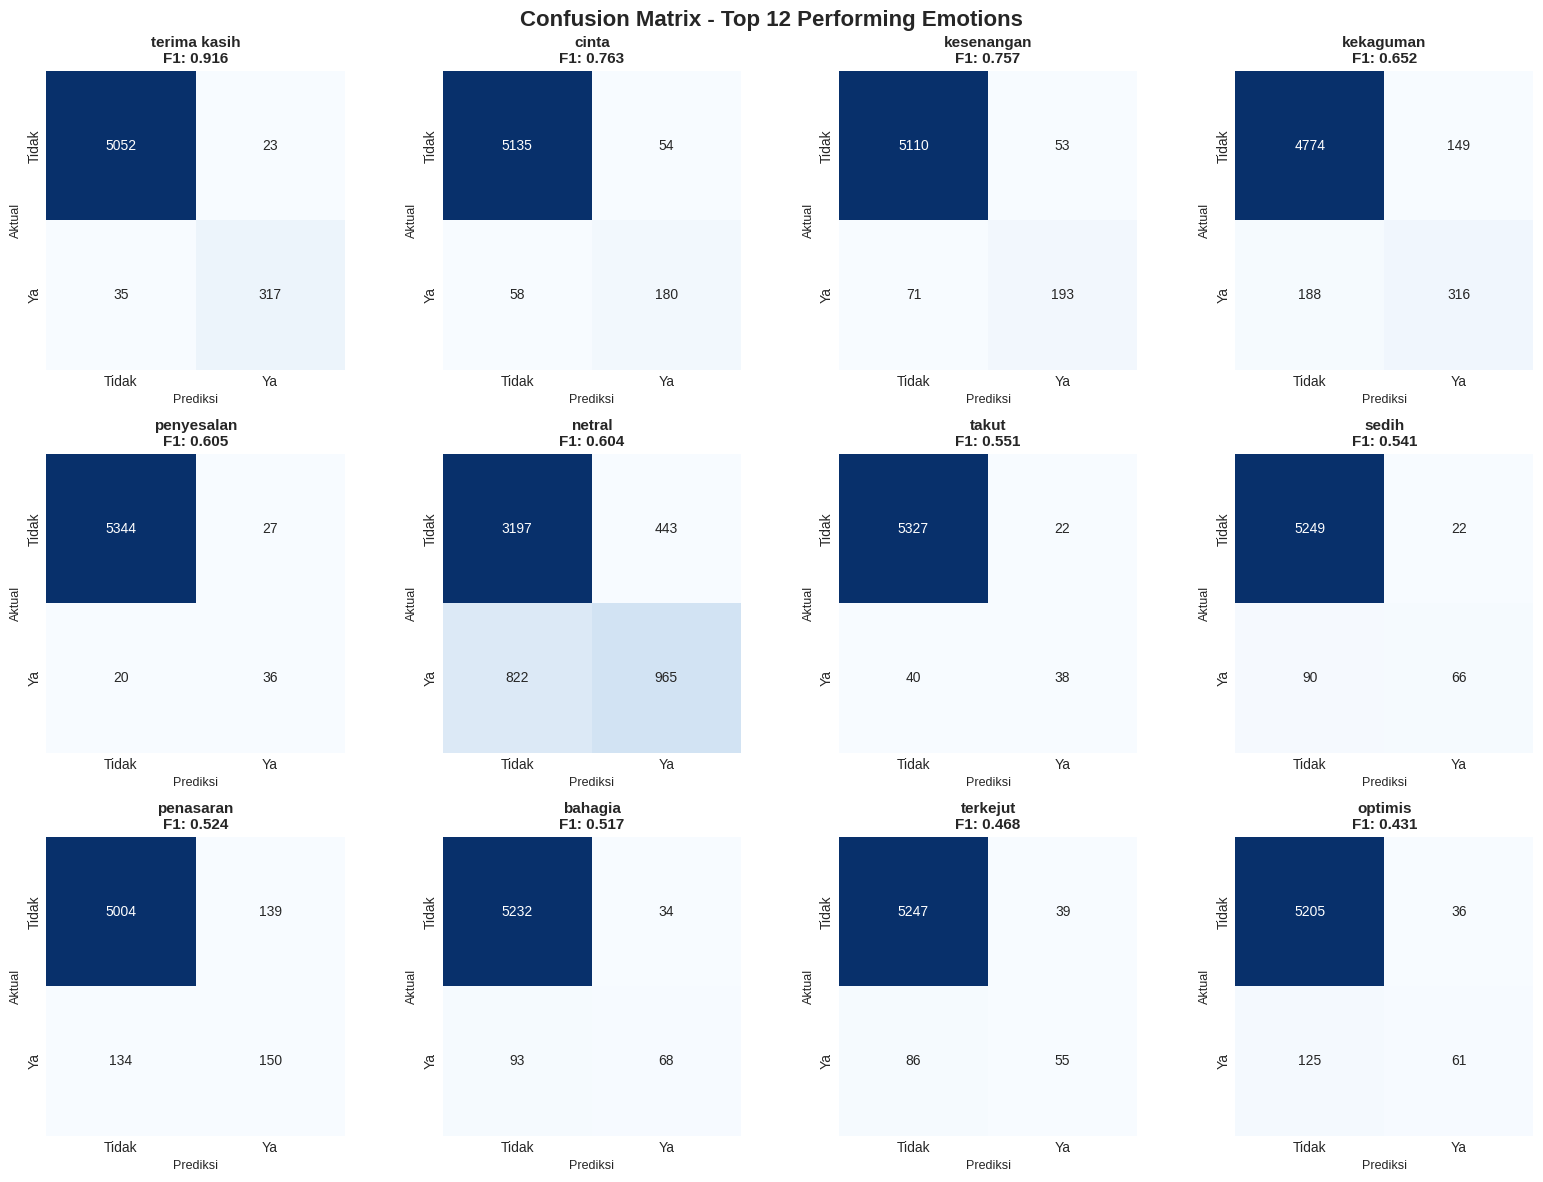

Presentation-ready confusion matrix saved as 'presentation_confusion_matrix.png'

FINAL RECOMMENDATIONS
📊 PERFORMANCE OVERVIEW:
   Best F1-Score: 0.9162 (terima kasih)
   Worst F1-Score: 0.0000 (bangga)
   Average F1-Score: 0.3759
   Performance Range: 0.9162

💡 ACTIONABLE RECOMMENDATIONS:
1. 🔄 RETRAIN MODEL: Overall performance is low, consider:
   - Increasing training epochs
   - Adjusting learning rate
   - Using class weights for imbalanced data

🎯 NEXT STEPS:
1. Analyze per-emotion confusion matrices in detail
2. Implement threshold optimization
3. Consider ensemble methods for difficult emotions
4. Validate results on additional test data

📁 Generated files:
- comprehensive_multilabel_evaluation.xlsx
- detailed_confusion_matrix_analysis.csv
- multilabel_confusion_matrix_individual.png
- multilabel_confusion_matrix_performance_heatmap.png
- multilabel_confusion_matrix_distribution_analysis.png
- presentation_confusion_matrix.png
- evaluation_summary_report.txt


In [26]:
# Display confusion matrix results in an easy-to-read format
def display_confusion_matrix_summary():
    """
    Display a comprehensive summary of confusion matrix results.
    """
    print(f"\n{'='*100}")
    print("CONFUSION MATRIX SUMMARY - ALL 28 EMOTIONS")
    print(f"{'='*100}")
    
    # Create a detailed table
    print(f"{'No':<3} {'Emotion':<15} {'TP':<4} {'FP':<4} {'FN':<4} {'TN':<6} {'Prec':<6} {'Rec':<6} {'F1':<6} {'Supp':<5}")
    print("-" * 100)
    
    for idx, (_, row) in enumerate(performance_df.iterrows()):
        print(f"{idx+1:<3} {row['Emotion']:<15} {int(row['True_Positive']):<4} {int(row['False_Positive']):<4} "
              f"{int(row['False_Negative']):<4} {int(row['True_Negative']):<6} {row['Precision']:<6.3f} "
              f"{row['Recall']:<6.3f} {row['F1-Score']:<6.3f} {int(row['Support']):<5}")
    
    print("-" * 100)
    print(f"TOTAL SAMPLES: {len(y_true_matrix)}")
    print(f"AVERAGE METRICS - Precision: {performance_df['Precision'].mean():.3f}, "
          f"Recall: {performance_df['Recall'].mean():.3f}, F1: {performance_df['F1-Score'].mean():.3f}")
    
    # Emotion categories analysis
    print(f"\n{'='*60}")
    print("EMOTION CATEGORIES ANALYSIS")
    print(f"{'='*60}")
    
    # High performers (F1 > 0.5)
    high_performers = performance_df[performance_df['F1-Score'] > 0.5]
    if len(high_performers) > 0:
        print(f"✅ HIGH PERFORMERS (F1 > 0.5): {len(high_performers)} emotions")
        print(f"   {', '.join(high_performers['Emotion'].tolist())}")
    
    # Medium performers (0.3 <= F1 <= 0.5)
    medium_performers = performance_df[(performance_df['F1-Score'] >= 0.3) & (performance_df['F1-Score'] <= 0.5)]
    if len(medium_performers) > 0:
        print(f"🟡 MEDIUM PERFORMERS (0.3 ≤ F1 ≤ 0.5): {len(medium_performers)} emotions")
        print(f"   {', '.join(medium_performers['Emotion'].tolist())}")
    
    # Low performers (F1 < 0.3)
    low_performers = performance_df[performance_df['F1-Score'] < 0.3]
    if len(low_performers) > 0:
        print(f"⚠️  LOW PERFORMERS (F1 < 0.3): {len(low_performers)} emotions")
        print(f"   {', '.join(low_performers['Emotion'].tolist())}")
    
    # Data imbalance analysis
    print(f"\n{'='*60}")
    print("DATA DISTRIBUTION ANALYSIS")
    print(f"{'='*60}")
    
    # Low support emotions
    low_support = performance_df[performance_df['Support'] < 50]
    if len(low_support) > 0:
        print(f"📉 LOW SUPPORT EMOTIONS (< 50 samples): {len(low_support)} emotions")
        print(f"   {', '.join(low_support['Emotion'].tolist())}")
    
    # High support emotions
    high_support = performance_df[performance_df['Support'] > 500]
    if len(high_support) > 0:
        print(f"📈 HIGH SUPPORT EMOTIONS (> 500 samples): {len(high_support)} emotions")
        print(f"   {', '.join(high_support['Emotion'].tolist())}")
    
    # Problem patterns
    print(f"\n{'='*60}")
    print("PROBLEM PATTERN ANALYSIS")
    print(f"{'='*60}")
    
    # High false positives
    high_fp = performance_df[performance_df['False_Positive'] > performance_df['True_Positive']]
    if len(high_fp) > 0:
        print(f"🚨 HIGH FALSE POSITIVES (FP > TP): {len(high_fp)} emotions")
        print(f"   {', '.join(high_fp['Emotion'].tolist())}")
        print(f"   → Model over-predicts these emotions")
    
    # High false negatives
    high_fn = performance_df[performance_df['False_Negative'] > performance_df['True_Positive']]
    if len(high_fn) > 0:
        print(f"🚨 HIGH FALSE NEGATIVES (FN > TP): {len(high_fn)} emotions")
        print(f"   {', '.join(high_fn['Emotion'].tolist())}")
        print(f"   → Model under-predicts these emotions")
    
    # No true positives
    no_tp = performance_df[performance_df['True_Positive'] == 0]
    if len(no_tp) > 0:
        print(f"💀 ZERO TRUE POSITIVES: {len(no_tp)} emotions")
        print(f"   {', '.join(no_tp['Emotion'].tolist())}")
        print(f"   → Model never correctly predicts these emotions")

# Display the summary
display_confusion_matrix_summary()

# Create a simplified confusion matrix visualization for presentation
def create_presentation_confusion_matrix():
    """
    Create a simplified confusion matrix visualization suitable for presentations.
    """
    # Select top 12 emotions by F1-score for visualization
    top_emotions = performance_df.head(12)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, (_, row) in enumerate(top_emotions.iterrows()):
        emotion_idx = [idx for idx, name in enumerate(emotion_names) if name == row['Emotion']][0]
        cm = confusion_matrix(y_true_matrix[:, emotion_idx], y_pred_matrix[:, emotion_idx])
        
        # Ensure we have a 2x2 matrix
        if cm.shape == (1, 1):
            if y_true_matrix[:, emotion_idx].sum() == 0:
                cm = np.array([[cm[0,0], 0], [0, 0]])
            else:
                cm = np.array([[0, 0], [0, cm[0,0]]])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Tidak', 'Ya'], yticklabels=['Tidak', 'Ya'],
                   cbar=False, square=True)
        
        axes[i].set_title(f"{row['Emotion']}\nF1: {row['F1-Score']:.3f}", 
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Prediksi', fontsize=9)
        axes[i].set_ylabel('Aktual', fontsize=9)
    
    plt.suptitle('Confusion Matrix - Top 12 Performing Emotions', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('presentation_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Presentation-ready confusion matrix saved as 'presentation_confusion_matrix.png'")

# Create presentation visualization
create_presentation_confusion_matrix()

# Generate final recommendations
print(f"\n{'='*80}")
print("FINAL RECOMMENDATIONS")
print(f"{'='*80}")

best_f1 = performance_df['F1-Score'].max()
worst_f1 = performance_df['F1-Score'].min()
avg_f1 = performance_df['F1-Score'].mean()

print(f"📊 PERFORMANCE OVERVIEW:")
print(f"   Best F1-Score: {best_f1:.4f} ({performance_df.iloc[0]['Emotion']})")
print(f"   Worst F1-Score: {worst_f1:.4f} ({performance_df.iloc[-1]['Emotion']})")
print(f"   Average F1-Score: {avg_f1:.4f}")
print(f"   Performance Range: {best_f1 - worst_f1:.4f}")

print(f"\n💡 ACTIONABLE RECOMMENDATIONS:")

if avg_f1 < 0.4:
    print("1. 🔄 RETRAIN MODEL: Overall performance is low, consider:")
    print("   - Increasing training epochs")
    print("   - Adjusting learning rate")
    print("   - Using class weights for imbalanced data")
elif avg_f1 < 0.6:
    print("1. 🎯 FINE-TUNE MODEL: Good baseline, focus on:")
    print("   - Optimizing threshold per emotion")
    print("   - Collecting more data for low-performing emotions")
else:
    print("1. ✅ EXCELLENT PERFORMANCE: Model is working well")

if len(performance_df[performance_df['Support'] < 50]) > 5:
    print("2. 📈 DATA AUGMENTATION: Many emotions have low support")
    print("   - Generate synthetic data for rare emotions")
    print("   - Collect more real-world examples")

if len(performance_df[performance_df['False_Positive'] > performance_df['True_Positive']]) > 3:
    print("3. 🎚️  THRESHOLD OPTIMIZATION: High false positive rates")
    print("   - Increase threshold for over-predicted emotions")
    print("   - Use emotion-specific thresholds")

print(f"\n🎯 NEXT STEPS:")
print("1. Analyze per-emotion confusion matrices in detail")
print("2. Implement threshold optimization")
print("3. Consider ensemble methods for difficult emotions")
print("4. Validate results on additional test data")

print(f"\n📁 Generated files:")
print("- comprehensive_multilabel_evaluation.xlsx")
print("- detailed_confusion_matrix_analysis.csv")
print("- multilabel_confusion_matrix_individual.png")
print("- multilabel_confusion_matrix_performance_heatmap.png")
print("- multilabel_confusion_matrix_distribution_analysis.png")
print("- presentation_confusion_matrix.png")
print("- evaluation_summary_report.txt")

In [27]:
torch.save(model.state_dict(), "indobert_multilabel_best.pt")
model.load_state_dict(torch.load("indobert_multilabel_best.pt"))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e